Calibra los espectros de (frecuencia, cuentas) a (velocidad, temperatura) y guárdalos en el directorio "calibrated_spectra".

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import csv
import scipy as sp
from scipy.ndimage import median_filter
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
from datetime import datetime
import pandas as pd
# import plot_params
%matplotlib inline

In [ ]:
# function to convert frequency to HI radial velocity
def convert_nu_to_vrad(nu):
    nu0 = 1420.405751   # rest frequency of HI in MHz
    c = 2.99792458e5    # speed of light in km/s
    vrad = (nu0-nu) * c / nu0
    return vrad

In [ ]:
# function to read in all the files in a directory and calculate the average spectrum (counts at each frequency channel)
def avespec(directory):
    # get the list of all spectra (csv files) in directory
    files = glob.glob(directory + '/*.csv')
    # you can print out the result to make sure its doing the right thing
    #print(files)

    # read in the first file to initialize the sum
    nu0, C_sum = np.genfromtxt(files[0], delimiter=',', unpack=True)

    # loop through all the other files and sum the counts
    for f in files[1:]:
        nu1, C1 = np.genfromtxt(f, delimiter=',', unpack=True)
        if np.array_equal(nu0,nu1):
            C_sum += C1
        else:
            print('Error: frequency axes are different in avespec')
            return False, False

    # divide by the number of files to produce the average
    C_ave = C_sum / len(files)

    return nu0, C_ave

In [ ]:
# function to calibrate the spectra in a given subdirectory (e.g., 'lon30'); average, convert to temperature units and median filter to remove spikes
def counts2temperature(dir):
    nu, C = avespec(dir)

    if not np.array_equal(nu,nu_cal):
        print('Error: frequency axes are different from calibration')
        return False, False

    vrad = convert_nu_to_vrad(nu)
    try:
        Tsrc = median_filter(C/G - Tr, size=5)
    except:
        print('First read in caibration file to convert spectra to temperature')
    return vrad, Tsrc

In [ ]:
# Mount Google Drive

# Set the path to the data directory
path = '/content/drive/MyDrive/Python/example_data'
os.chdir(path)
filelist = os.listdir()
cwd = os.getcwd()

Creating subdirectory calibrated_spectra  in  /content/drive/MyDrive/Python


In [ ]:
# read in the receiver temperature and gain, determined from calibrate.ipynb
nu_cal, Tr, G = np.genfromtxt('/content/drive/MyDrive/Python/calibration.csv', delimiter=',', unpack=True)

In [ ]:
# loop through the spectra, average each longitude, calibrate, and write out

for f in os.listdir():
    if os.path.isdir(f) and f[0:3] == 'lon':
        print(f)
        cal_subdir = 'calibrated_spectra'
        cal_dir = '/content/drive/MyDrive/Python/' + cal_subdir
        if not os.path.isdir(cal_dir):
            print('Creating subdirectory', cal_subdir, ' in ', '/content/drive/MyDrive/Python')
            os.mkdir(cal_dir)

        v, T = counts2temperature(f)
        ff = f+'_cal.csv'
        print('Writing calibrated spectrum to ', ff)
        with open(cal_dir + '/' + ff, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(zip(v[::-1], T[::-1]))

lon50
Writing calibrated spectrum to  lon50_cal.csv
lon80
Writing calibrated spectrum to  lon80_cal.csv
lon20
Writing calibrated spectrum to  lon20_cal.csv
lon30
Writing calibrated spectrum to  lon30_cal.csv
lon40
Writing calibrated spectrum to  lon40_cal.csv
lon70
Writing calibrated spectrum to  lon70_cal.csv
lon90
Writing calibrated spectrum to  lon90_cal.csv
lon10
Writing calibrated spectrum to  lon10_cal.csv
lon60
Writing calibrated spectrum to  lon60_cal.csv


<Figure size 640x480 with 0 Axes>

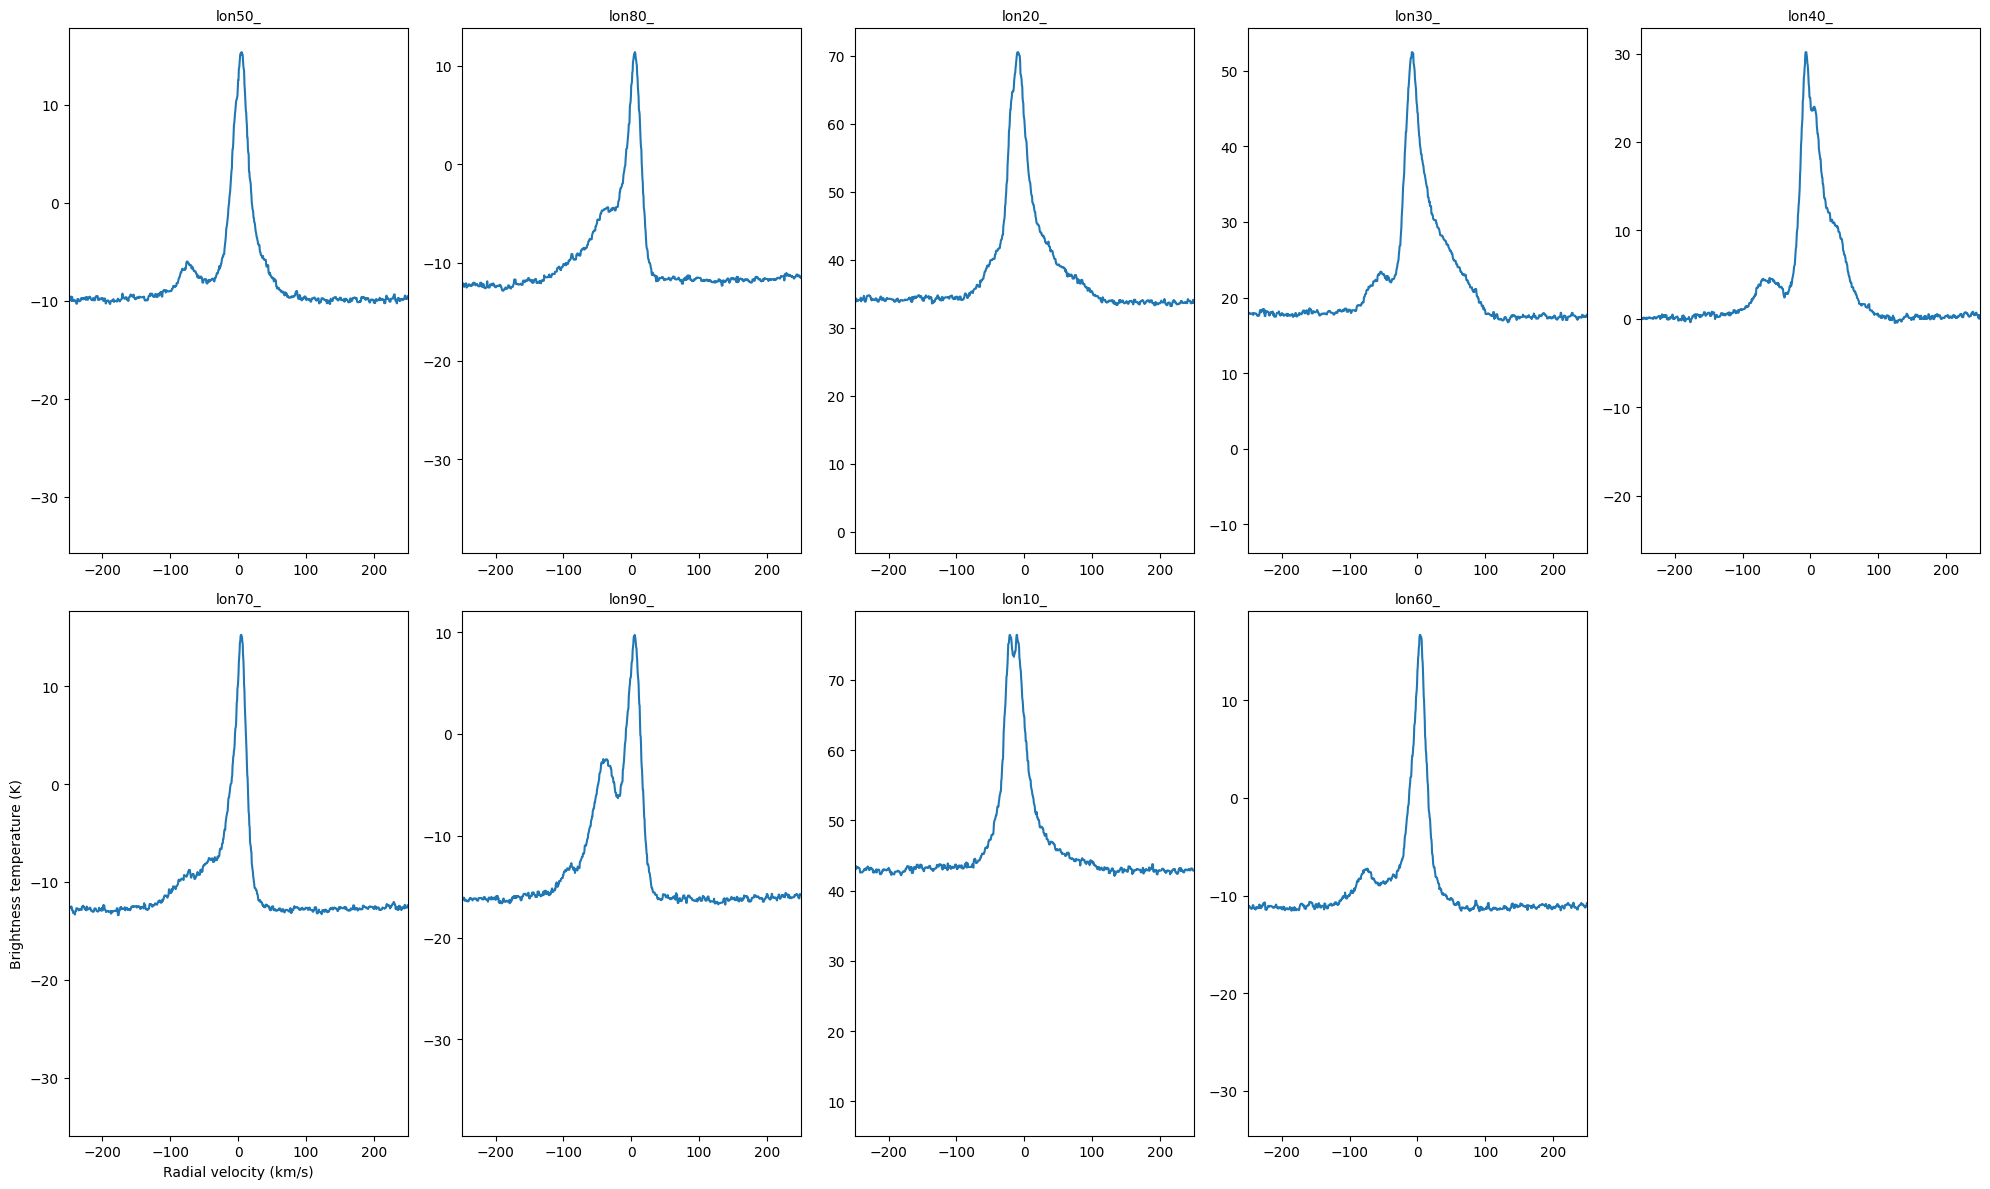

In [ ]:
# look at the flattened spectra
# and determine the velocity range for doing the next (baseline) step
plt.clf()
files = glob.glob('/content/drive/MyDrive/Python/calibrated_spectra/*.csv')
nfiles = len(files)
fig = plt.figure(figsize=(20, 12))
ny = 5
nx = nfiles / 5 + 1

for n, f in enumerate(files):
    v, T = np.genfromtxt(f, delimiter=',', unpack=True)
    ax = fig.add_subplot(int(nx), int(ny), int(n + 1))
    ax.plot(v, T)
    label = os.path.basename(f)[:-7]  # Extract filename without '.csv' extension
    ax.set_title(label, fontsize=10)
    ax.set_xlim(-250, 250)

    # label the bottom left spectrum
    if n == 5:
        ax.set_xlabel('Radial velocity (km/s)')
        ax.set_ylabel('Brightness temperature (K)')

plt.tight_layout()
save_path = '/content/drive/MyDrive/Python/calibrated_spectra.png'
plt.savefig(save_path)